In [9]:
import arviz as az
import pandas as pd
import json

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import jax
import itertools
import sys
import math
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
sys.path.insert(0, '/home/nlinden/.matplotlib/')
from plotting_helper_funcs import *

from scipy.special import comb

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


Now load in all of the posterior idata and the posterior predictive samples...

In [10]:
# Kholodenko 2000
K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/kholodenko_2000/kholodenko_2000_smc_samples.json')
K_2000_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/kholodenko_2000/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/levchenko_2000/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/levchenko_2000/levchenko_2000_posterior_predictive_samples.npy')
# # Hatakeyama 2003
# HK_2003_idata, HK_2003_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/hatakeyama_2003/hatakeyama_2003_smc_samples.json')
# HK_2003_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/hatakeyama_2003/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
H_2005_idata, H_2005_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/hornberg_2005/hornberg_2005_smc_samples.json')
H_2005_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/hornberg_2005/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
B_2007_idata, B_2007_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/birtwistle_2007/birtwistle_2007_smc_samples.json')
B_2007_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/birtwistle_2007/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/orton_2009/orton_2009_smc_samples.json')
O_2009_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/orton_2009/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
vK_2009_idata, VK_2009_ss= load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_smc_samples.json')
vK_2009_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/shin_2014/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/shin_2014/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/ryu_2015/ryu_2015_smc_samples.json')
R_2015_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/ryu_2015/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/kochanczyk_2017/kochanczyk_2017_smc_samples.json')
K_2017_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/kochanczyk_2017/kochanczyk_2017_posterior_predictive_samples.npy')

# Log marginal likelihoods
S_2014_log_magr = np.mean([chain[-1] for chain in S_2014_ss['log_marginal_likelihood'][0]])
K_2000_log_magr = np.mean([chain[-1] for chain in K_2000_ss['log_marginal_likelihood'][0]])
vK_2009_log_magr = np.mean([chain[-1] for chain in VK_2009_ss['log_marginal_likelihood'][0]]) 
O_2009_log_magr = np.mean([chain[-1] for chain in O_2009_ss['log_marginal_likelihood'][0]])
R_2015_log_magr = np.mean([chain[-1] for chain in R_2015_ss['log_marginal_likelihood'][0]])
L_2000_log_magr = np.mean([chain[-1] for chain in L_2000_ss['log_marginal_likelihood'][0]])
K_2017_log_magr = np.mean([chain[-1] for chain in K_2017_ss['log_marginal_likelihood']])
B_2007_log_magr = np.mean([chain[-1] for chain in B_2007_ss['log_marginal_likelihood'][0]])
H_2005_log_magr = np.mean([chain[-1] for chain in H_2005_ss['log_marginal_likelihood'][0]])


# Hornberg 2005 only has 560 posterior predictive samples, so we duplicate and randomly permute them to get 2000
H_2005_posts = [H_2005_post for _ in range(10)]
H_2005_post = np.vstack(H_2005_posts)
H_2005_post = H_2005_post[rng.permutation(np.arange(2000))]

# Orton 2009 only has 800 posterior predictive samples, so we duplicate and randomly permute them to get 2000
O_2009_posts = [O_2009_post for _ in range(10)]
O_2009_post = np.vstack(O_2009_posts)
O_2009_post = O_2009_post[rng.permutation(np.arange(2000))]

#von Kriegsheim 2009 only has 600 posterior predictive samples, so we duplicate and randomly permute them to get 2000
vK_2009_posts = [vK_2009_post for _ in range(10)]
vK_2009_post = np.vstack(vK_2009_posts)
vK_2009_post = vK_2009_post[rng.permutation(np.arange(2000))]

# shin has 4000 so downsample to 2000
idxs = rng.choice(np.arange(4000), size=2000, replace=False)
S_2014_post = S_2014_post[idxs]

# get data
# dose-response
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')
# trajectory
inputs_traj, data_traj, data_std_traj, times_traj = load_data_json('../../../results/MAPK/HF_96_traj_data.json', data_std=True, time=True)
data_time_to_mins = 60

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest purple
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
orange = '#de8f05'

We want to construct MMI estimators with decreasing numbers of models from 9 to 2

In [11]:
# function to compute model probs
def logsumexp(x):
        c = np.max(x)
        return c + np.log(np.sum(np.exp(x - c)))

def weight_with_logsumexp(log_values):
    return np.exp(log_values - logsumexp(log_values))

def model_probs(log_marginal_likes):
    """Computes the model probabilities from a list of log marginal likelihoods."""

    n_models = len(log_marginal_likes)
    prior_prob = 1/n_models
    model_probs = weight_with_logsumexp(np.log(prior_prob)+log_marginal_likes)
    

    return model_probs

Compute MMI and associated uncertainty for all models

In [12]:
# set up model names and display names and other data for all models
model_names_all = ['kholodenko_2000', 'levchenko_2000','hornberg_2005', 'birtwistle_2007','orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names_all = ["K' 2000", "L' 2000", "H' 2005", "B' 2007","O' 2009", "vK' 2009", "S' 2014", "R' 2015", "K' 2017"]
log_marginal_likes_all = np.array([K_2000_log_magr, L_2000_log_magr, H_2005_log_magr, B_2007_log_magr, O_2009_log_magr, vK_2009_log_magr, S_2014_log_magr, R_2015_log_magr, K_2017_log_magr])
dict_compare_all = {'kholodenko_2000': K_2000_idata, 'levchenko_2000':L_2000_idata,'hornberg_2005':H_2005_idata,'birtwistle_2007':B_2007_idata,'orton_2009':O_2009_idata, 'vonKriegsheim_2009':vK_2009_idata, 'shin_2014': S_2014_idata, 'ryu_2015': R_2015_idata, 'kochanczyk_2017':K_2017_idata}
posterior_samples_all = [K_2000_post, L_2000_post, H_2005_post, B_2007_post, O_2009_post, vK_2009_post, S_2014_post, R_2015_post, K_2017_post]


compare_data_loo_pbma_all = az.compare(dict_compare_all, ic='loo', method='BB-pseudo-BMA')
compare_data_loo_stack_all = az.compare(dict_compare_all, ic='loo', method='stacking')
model_probs_all = model_probs(log_marginal_likes_all)
stack_weight_all = [compare_data_loo_stack_all.loc[model]['weight'] for model in model_names_all]
pBMA_weight_all = [compare_data_loo_pbma_all.loc[model]['weight'] for model in model_names_all]

loo_pbma_combined_all = np.zeros_like(posterior_samples_all[0])
loo_stack_combined_all = np.zeros_like(posterior_samples_all[0])
loo_bma_combined_all = np.zeros_like(posterior_samples_all[0])
for i, name in enumerate(model_names_all):
    loo_pbma_combined_all += compare_data_loo_pbma_all.loc[name]['weight']*posterior_samples_all[i]
    loo_stack_combined_all += compare_data_loo_stack_all.loc[name]['weight']*posterior_samples_all[i]
    loo_bma_combined_all += model_probs_all[i]*posterior_samples_all[i]


# compute errors of all models
RMSE_models_all = []
errors_models_all = []
for i, name in enumerate(model_names_all):
    RMSE_models_all.append(np.sqrt(np.nanmean((np.nanmean(posterior_samples_all[i] - data_traj, axis=0))**2)))
    errors_models_all.append(np.linalg.norm(np.nanmean(posterior_samples_all[i] - data_traj, axis=0))/np.linalg.norm(data_traj))

# MMI w/ all
RMSE_all = []

RMSE_all.append(np.sqrt(np.nanmean((np.nanmean(loo_pbma_combined_all - data_traj, axis=0))**2)))
RMSE_all.append(np.sqrt(np.nanmean((np.nanmean(loo_stack_combined_all - data_traj, axis=0))**2)))
RMSE_all.append(np.sqrt(np.nanmean((np.nanmean(loo_bma_combined_all - data_traj, axis=0))**2)))

error_all = []

error_all.append(np.linalg.norm(np.nanmean(loo_pbma_combined_all - data_traj, axis=0))/np.linalg.norm(data_traj))
error_all.append(np.linalg.norm(np.nanmean(loo_stack_combined_all - data_traj, axis=0))/np.linalg.norm(data_traj))
error_all.append(np.linalg.norm(np.nanmean(loo_bma_combined_all - data_traj, axis=0))/np.linalg.norm(data_traj))

# Just models
uncert_95_models_all = []
for i, name in enumerate(model_names_all):
    uncert_95_models_all.append(np.nanmean(np.diff(np.nanquantile(posterior_samples_all[i], [0.025, 0.975], axis=0), axis=0)))

# MMI w/ all
uncert_95_all = []

uncert_95_all.append(np.nanmean(np.diff(np.nanquantile(loo_pbma_combined_all, [0.025, 0.975], axis=0), axis=0)))
uncert_95_all.append(np.nanmean(np.diff(np.nanquantile(loo_stack_combined_all, [0.025, 0.975], axis=0), axis=0)))
uncert_95_all.append(np.nanmean(np.diff(np.nanquantile(loo_bma_combined_all, [0.025, 0.975], axis=0), axis=0)))


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

Now run for all combinatoric subsets of models

In [13]:
n_models = 9
n_combos = sum([comb(n_models, i) for i in range(1, n_models)])
count = 0
errors_pBMA = {}
RMSE_pBMA = {}
uncertainties_pBMA = {}
errors_BMA = {}
RMSE_BMA = {}
uncertainties_BMA = {}
errors_stack = {}
RMSE_stack = {}
uncertainties_stack = {}

model_sets = {}

for subset_length in range(1, n_models):
    print('Running {} models'.format(subset_length))
    RMSE_pBMA[subset_length] = []
    errors_pBMA[subset_length] = []
    uncertainties_pBMA[subset_length] = []
    errors_BMA[subset_length] = []
    RMSE_BMA[subset_length] = []
    uncertainties_BMA[subset_length] = []
    errors_stack[subset_length] = []
    RMSE_stack[subset_length] = []
    uncertainties_stack[subset_length] = []

    # loop over all possible combinations of models at this subset length
    for subset_idxs in itertools.combinations(range(n_models), subset_length):
        # get the model names for this subset
        model_subset = [model_names_all[idx] for idx in subset_idxs]

        # get the log marginal likelihoods and idata for the subset of models
        log_marg_subset = log_marginal_likes_all[list(subset_idxs)]
        posterior_samples_subset = [posterior_samples_all[idx] for idx in subset_idxs]
        dict_compare_subset = {model: dict_compare_all[model] for model in model_subset}

        if subset_length == 1:
            # if there's only one model, the model probabilities are 1
            model_probs_subset = np.array([1])
            pBMA_weight = np.array([1])
            stack_weight = np.array([1])
        else:
            # compute the model probabilities
            model_probs_subset = model_probs(log_marg_subset)

            # compute pBMA weights
            compare_data_loo_pbma_subset = az.compare(dict_compare_subset, ic='loo', method='BB-pseudo-BMA')
            pBMA_weight = [compare_data_loo_pbma_subset.loc[model]['weight'] for model in model_subset]

            # compute stacking weights
            compare_data_loo_stack_subset = az.compare(dict_compare_subset, ic='loo', method='stacking')
            stack_weight= [compare_data_loo_stack_subset.loc[model]['weight'] for model in model_subset]

        # compute the combined posterior samples
        loo_pbma_combined_subset = np.zeros_like(posterior_samples_subset[0])
        loo_stack_combined_subset = np.zeros_like(posterior_samples_subset[0])
        loo_bma_combined_subset = np.zeros_like(posterior_samples_subset[0])
        for j, name in enumerate(model_subset):
            loo_pbma_combined_subset += pBMA_weight[j]*posterior_samples_subset[j]
            loo_stack_combined_subset += stack_weight[j]*posterior_samples_subset[j]
            loo_bma_combined_subset += model_probs_subset[j]*posterior_samples_subset[j]

        # compute the errors and uncertainties
        RMSE_pBMA[subset_length].append(np.sqrt(np.nanmean((np.nanmean(loo_pbma_combined_subset - data_traj, axis=0))**2)))
        RMSE_stack[subset_length].append(np.sqrt(np.nanmean((np.nanmean(loo_stack_combined_subset - data_traj, axis=0))**2)))
        RMSE_BMA[subset_length].append(np.sqrt(np.nanmean((np.nanmean(loo_bma_combined_subset - data_traj, axis=0))**2)))

        errors_pBMA[subset_length].append(np.linalg.norm(np.nanmean(loo_pbma_combined_subset - data_traj, axis=0))/np.linalg.norm(data_traj))
        errors_BMA[subset_length].append(np.linalg.norm(np.nanmean(loo_bma_combined_subset - data_traj, axis=0))/np.linalg.norm(data_traj))
        errors_stack[subset_length].append(np.linalg.norm(np.nanmean(loo_stack_combined_subset - data_traj, axis=0))/np.linalg.norm(data_traj))

        uncertainties_pBMA[subset_length].append(np.nanmean(np.diff(np.nanquantile(loo_pbma_combined_subset, [0.025, 0.975], axis=0), axis=0)))
        uncertainties_stack[subset_length].append(np.nanmean(np.diff(np.nanquantile(loo_stack_combined_subset, [0.025, 0.975], axis=0), axis=0)))
        uncertainties_BMA[subset_length].append(np.nanmean(np.diff(np.nanquantile(loo_bma_combined_subset, [0.025, 0.975], axis=0), axis=0)))

Running 1 models
Running 2 models


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

Running 3 models


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

Running 4 models


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future erro

Running 5 models


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

Running 6 models


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

Running 7 models


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

Running 8 models


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

Make boc plots of dists of RMSE and uncertainty for each subset size

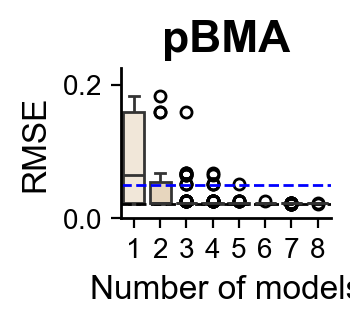

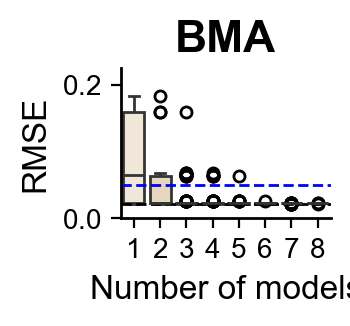

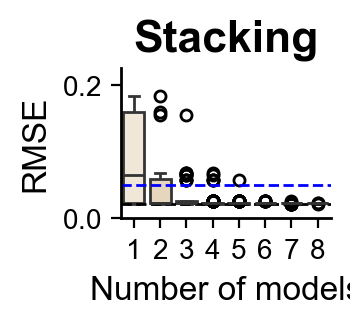

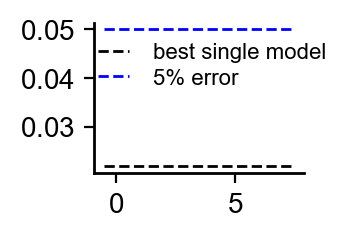

In [30]:
colors = sns.color_palette("OrRd", 8, desat=0.65)

# pBMA RMSE
width = 0.4
flierprops = dict(marker='o', markersize=4, markerfacecolor='None', markeredgecolor='black')
fig, ax = get_sized_fig_ax(1.05, 0.75)
# box = ax.boxplot(RMSE_pBMA.T, positions=np.arange(1, 9),
#                         widths=width, showfliers=True, patch_artist=False, 
#                         flierprops=dict(marker='o', markersize=0.75, markerfacecolor='k', markeredgecolor='k'),
#                         medianprops=dict(color='b', linewidth=1.0),)
box = sns.boxplot(RMSE_pBMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('RMSE')
ax.set_xlabel('Number of models')
ax.set_title('pBMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(RMSE_models_all), min(RMSE_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.225])

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_RMSE_pBMA.pdf', bbox_inches='tight', transparent=True)

# BMA RMSE
width = 0.4
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(RMSE_BMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('RMSE')
ax.set_xlabel('Number of models')
ax.set_title('BMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(RMSE_models_all), min(RMSE_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.225])

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_RMSE_BMA.pdf', bbox_inches='tight', transparent=True)

# stack RMSE
width = 0.4
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(RMSE_stack, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('RMSE')
ax.set_xlabel('Number of models')
ax.set_title('Stacking')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(RMSE_models_all), min(RMSE_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.225])

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_RMSE_stacking.pdf', bbox_inches='tight', transparent=True)

fig, ax = get_sized_fig_ax(1.05, 0.75)
ax.plot([xlim[0], xlim[1]], [min(RMSE_models_all), min(RMSE_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
leg = ax.legend(['best single model', '5% error'], fontsize=8, loc='upper right', bbox_to_anchor=(1.2, 1.0), labelspacing=0.25)
export_legend(leg, filename='../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_error_legend.pdf')

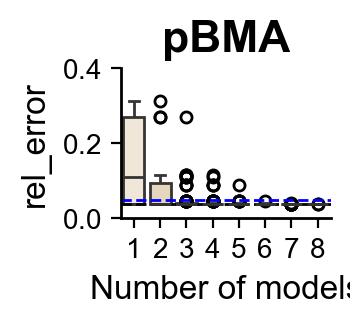

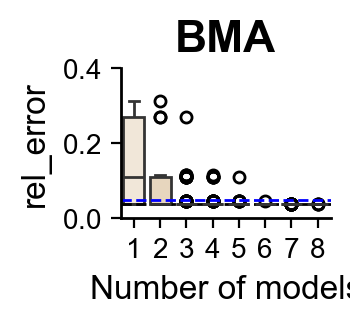

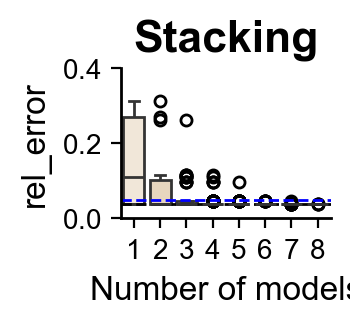

In [31]:
# pBMA rel_error
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(errors_pBMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('rel_error')
ax.set_xlabel('Number of models')
ax.set_title('pBMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(errors_models_all), min(errors_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.4])

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_rel_error_pBMA.pdf', bbox_inches='tight', transparent=True)

# BMA rel_error
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(errors_BMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('rel_error')
ax.set_xlabel('Number of models')
ax.set_title('BMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(errors_models_all), min(errors_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.4])

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_rel_error_BMA.pdf', bbox_inches='tight', transparent=True)

# stack rel_error
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(errors_stack, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('rel_error')
ax.set_xlabel('Number of models')
ax.set_title('Stacking')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(errors_models_all), min(errors_models_all)], 'k--', linewidth=1.0)
ax.plot([xlim[0], xlim[1]], [0.05, 0.05], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.4])

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_rel_error_stacking.pdf', bbox_inches='tight', transparent=True)

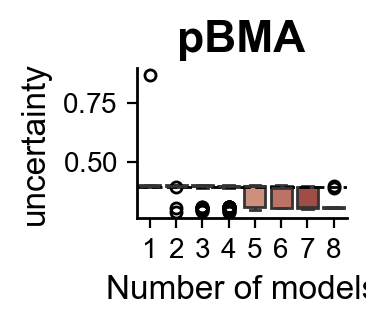

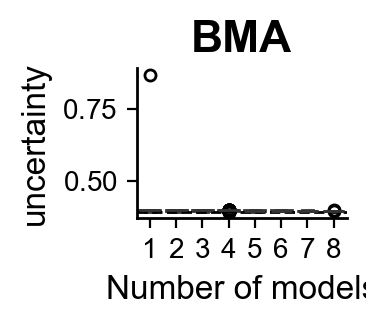

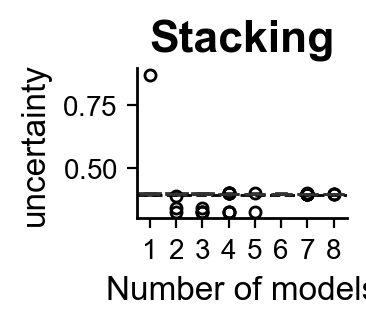

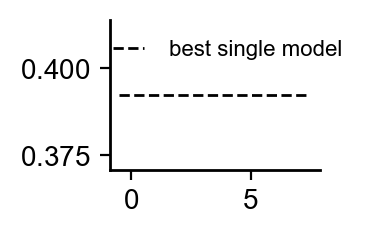

In [32]:
# pBMA uncertainty
width = 0.4
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(uncertainties_pBMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('uncertainty')
ax.set_xlabel('Number of models')
ax.set_title('pBMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(uncert_95_models_all), min(uncert_95_models_all)], 'k--', linewidth=1.0)
# ax.plot([xlim[0], xlim[1]], [1.1*min(uncert_95_models_all), 1.1*min(uncert_95_models_all)], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
# ax.set_ylim([0, 0.1])

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_uncert95_pBMA.pdf', bbox_inches='tight', transparent=True)

# BMA uncertainty
width = 0.4
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(uncertainties_BMA, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('uncertainty')
ax.set_xlabel('Number of models')
ax.set_title('BMA')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(uncert_95_models_all), min(uncert_95_models_all)], 'k--', linewidth=1.0)
# ax.plot([xlim[0], xlim[1]], [1.1*min(uncert_95_models_all), 1.1*min(uncert_95_models_all)], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
# ax.set_ylim([0, 0.1])

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_uncert95_BMA.pdf', bbox_inches='tight', transparent=True)

# stack uncertainty
width = 0.4
fig, ax = get_sized_fig_ax(1.05, 0.75)
box = sns.boxplot(uncertainties_stack, ax=ax, palette=colors, flierprops=flierprops)

ax.set_ylabel('uncertainty')
ax.set_xlabel('Number of models')
ax.set_title('Stacking')

xlim = ax.get_xlim()
ax.plot([xlim[0], xlim[1]], [min(uncert_95_models_all), min(uncert_95_models_all)], 'k--', linewidth=1.0)
# ax.plot([xlim[0], xlim[1]], [1.1*min(uncert_95_models_all), 1.1*min(uncert_95_models_all)], 'b--', linewidth=1.0)
ax.set_xlim(xlim)
# ax.set_ylim([0, 0.1])

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_uncert95_stacking.pdf', bbox_inches='tight', transparent=True)

fig, ax = get_sized_fig_ax(1.05, 0.75)
ax.plot([xlim[0], xlim[1]], [min(uncert_95_models_all), min(uncert_95_models_all)], 'k--', linewidth=1.0)
leg = ax.legend(['best single model'], fontsize=8, loc='upper right', bbox_to_anchor=(1.2, 1.0))
export_legend(leg, filename='../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_uncert95_legend.pdf')

In [17]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", grid_col='w', **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color=grid_col, linestyle='-', linewidth=1.0)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

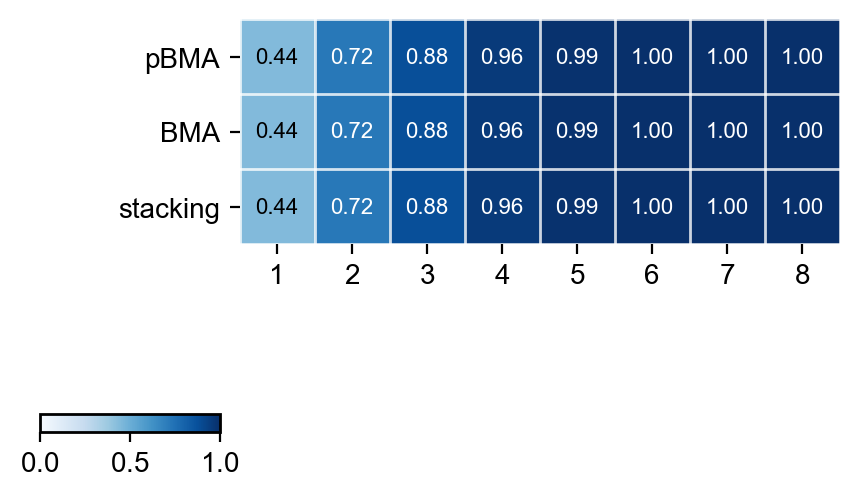

In [29]:
threshold = 0.05
pBMA = [np.sum(np.array(RMSE_pBMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in RMSE_pBMA.keys()]
BMA = [np.sum(np.array(RMSE_BMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in RMSE_BMA.keys()]
stacking = [np.sum(np.array(RMSE_stack[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in RMSE_stack.keys()]
RMSE_matrix = np.vstack([pBMA, BMA, stacking])

fig, ax = get_sized_fig_ax(3.0, 2.0)
im, cbar = heatmap(RMSE_matrix, 
        ['pBMA','BMA','stacking'],
        np.arange(1,9), ax=ax, vmin=0.0, vmax=1.0,
            cbar_kw={'aspect':10, 'shrink':0.15, 'panchor':False, 'anchor':(0, 0),'orientation':'horizontal'}, cbarlabel='', cmap='Blues',)

# cbar.set_ticks([cutoff, 0.25, 0.5, 0.75])
# cbar.set_ticklabels([r'p<0.05', '0.25', '0.5', '0.75'], fontsize=8.0)

text = annotate_heatmap(im, fontsize=8.0, threshold=0.5)

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_RMSE_005.pdf', bbox_inches='tight', transparent=True)

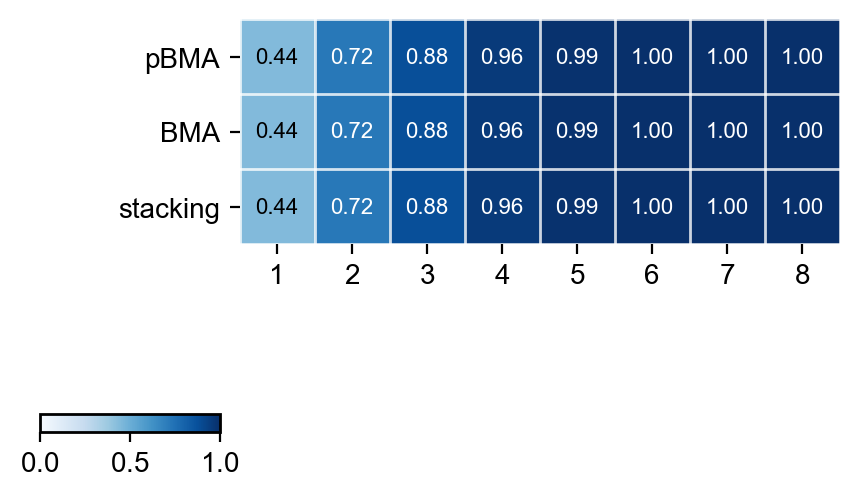

In [28]:
threshold = 0.03
pBMA = [np.sum(np.array(RMSE_pBMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in RMSE_pBMA.keys()]
BMA = [np.sum(np.array(RMSE_BMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in RMSE_BMA.keys()]
stacking = [np.sum(np.array(RMSE_stack[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in RMSE_stack.keys()]
RMSE_matrix = np.vstack([pBMA, BMA, stacking])

fig, ax = get_sized_fig_ax(3.0, 2.0)
im, cbar = heatmap(RMSE_matrix, 
        ['pBMA','BMA','stacking'],
        np.arange(1,9), ax=ax, vmin=0.0, vmax=1.0,
            cbar_kw={'aspect':10, 'shrink':0.15, 'panchor':False, 'anchor':(0, 0),'orientation':'horizontal'}, cbarlabel='', cmap='Blues',)

# cbar.set_ticks([cutoff, 0.25, 0.5, 0.75])
# cbar.set_ticklabels([r'p<0.05', '0.25', '0.5', '0.75'], fontsize=8.0)

text = annotate_heatmap(im, fontsize=8.0, threshold=0.5)

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_RMSE_003.pdf', bbox_inches='tight', transparent=True)

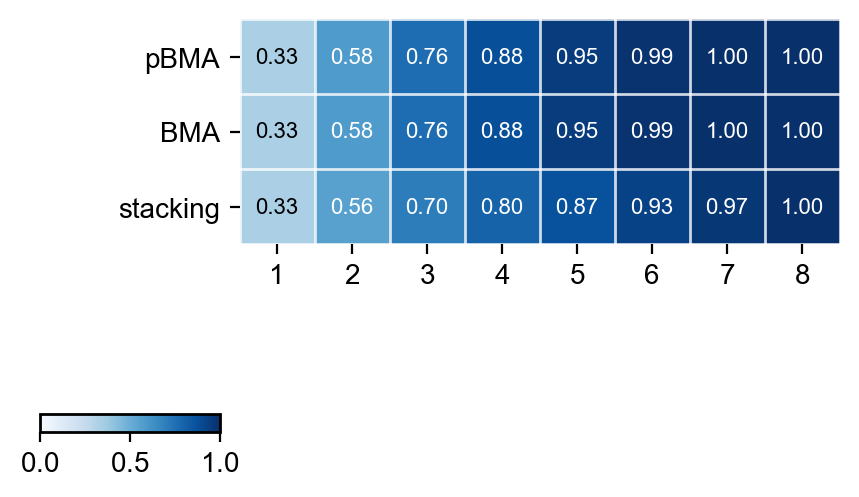

In [27]:
threshold = 1.2*min(RMSE_models_all)
pBMA = [np.sum(np.array(RMSE_pBMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in RMSE_BMA.keys()]
BMA = [np.sum(np.array(RMSE_BMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in RMSE_BMA.keys()]
stacking = [np.sum(np.array(RMSE_stack[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in RMSE_BMA.keys()]
RMSE_matrix = np.vstack([pBMA, BMA, stacking])

fig, ax = get_sized_fig_ax(3.0, 2.0)
im, cbar = heatmap(RMSE_matrix, 
        ['pBMA','BMA','stacking'],
        np.arange(1,9), ax=ax, vmin=0.0, vmax=1.0,
            cbar_kw={'aspect':10, 'shrink':0.15, 'panchor':False, 'anchor':(0, 0),'orientation':'horizontal'}, cbarlabel='', cmap='Blues',)

# cbar.set_ticks([cutoff, 0.25, 0.5, 0.75])
# cbar.set_ticklabels([r'p<0.05', '0.25', '0.5', '0.75'], fontsize=8.0)

text = annotate_heatmap(im, fontsize=8.0, threshold=0.5)

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_RMSE_20pct_bestModel.pdf', bbox_inches='tight')

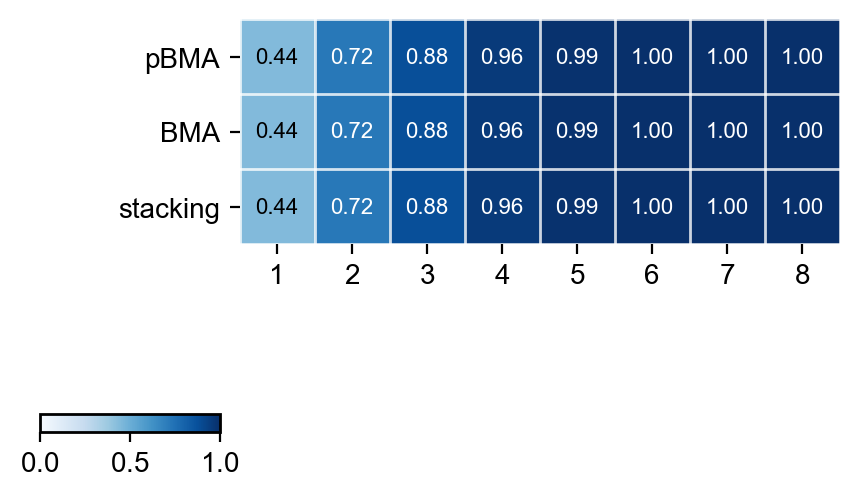

In [26]:
threshold = 0.05
pBMA = [np.sum(np.array(errors_pBMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in errors_BMA.keys()]
BMA = [np.sum(np.array(errors_BMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in errors_BMA.keys()]
stacking = [np.sum(np.array(errors_stack[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in errors_BMA.keys()]
rel_err_matrix = np.vstack([pBMA, BMA, stacking])

fig, ax = get_sized_fig_ax(3.0, 2.0)
im, cbar = heatmap(rel_err_matrix, 
        ['pBMA','BMA','stacking'],
        np.arange(1,9), ax=ax, vmin=0.0, vmax=1.0,
            cbar_kw={'aspect':10, 'shrink':0.15, 'panchor':False, 'anchor':(0, 0),'orientation':'horizontal'}, cbarlabel='', cmap='Blues',)

# cbar.set_ticks([cutoff, 0.25, 0.5, 0.75])
# cbar.set_ticklabels([r'p<0.05', '0.25', '0.5', '0.75'], fontsize=8.0)

text = annotate_heatmap(im, fontsize=8.0, threshold=0.5)

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_rel_error_005.pdf', bbox_inches='tight', transparent=True)

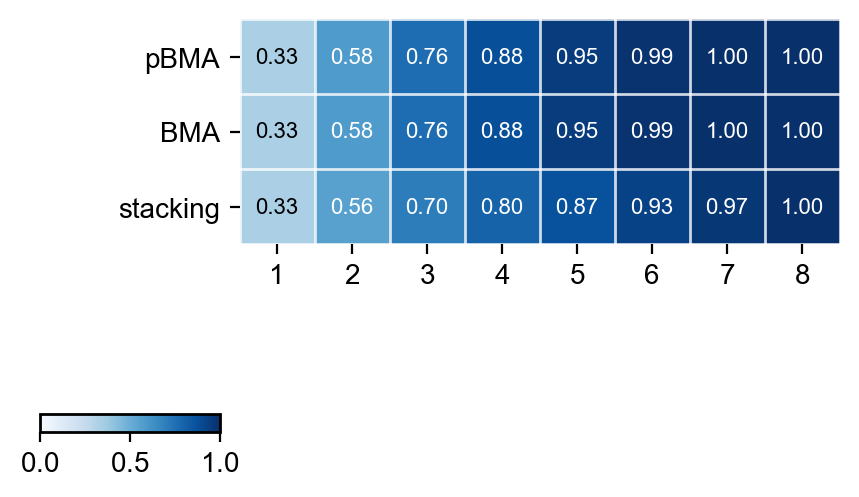

In [25]:
threshold = 1.2*min(errors_models_all)
pBMA = [np.sum(np.array(errors_pBMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in errors_BMA.keys()]
BMA = [np.sum(np.array(errors_BMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in errors_BMA.keys()]
stacking = [np.sum(np.array(errors_stack[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in errors_BMA.keys()]
rel_err_matrix = np.vstack([pBMA, BMA, stacking])

fig, ax = get_sized_fig_ax(3.0, 2.0)
im, cbar = heatmap(rel_err_matrix, 
        ['pBMA','BMA','stacking'],
        np.arange(1,9), ax=ax, vmin=0.0, vmax=1.0,
            cbar_kw={'aspect':10, 'shrink':0.15, 'panchor':False, 'anchor':(0, 0),'orientation':'horizontal'}, cbarlabel='', cmap='Blues',)

# cbar.set_ticks([cutoff, 0.25, 0.5, 0.75])
# cbar.set_ticklabels([r'p<0.05', '0.25', '0.5', '0.75'], fontsize=8.0)

text = annotate_heatmap(im, fontsize=8.0, threshold=0.5)

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_rel_error_20pct_bestModel.pdf', bbox_inches='tight')

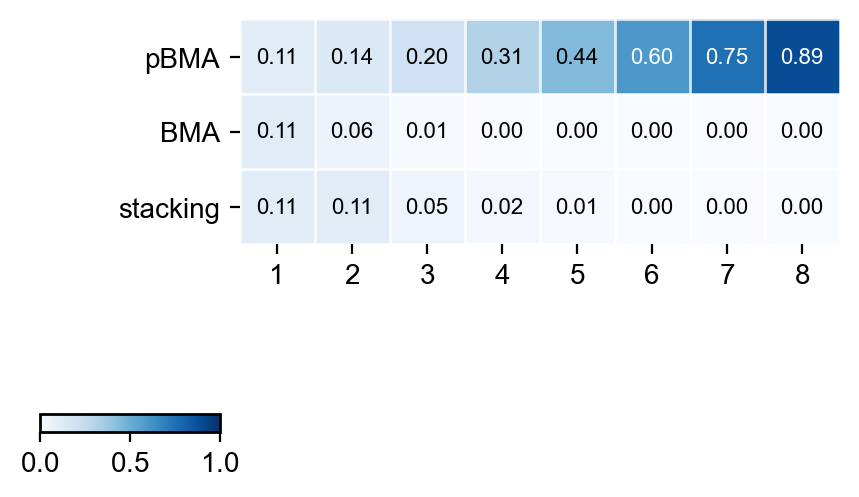

In [24]:
threshold = min(uncert_95_models_all)

pBMA = [np.sum(np.array(uncertainties_pBMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in uncertainties_BMA.keys()]
BMA = [np.sum(np.array(uncertainties_BMA[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in uncertainties_BMA.keys()]
stacking = [np.sum(np.array(uncertainties_stack[subset_length])<=threshold)/math.comb(n_models,subset_length) for subset_length in uncertainties_BMA.keys()]
uncert95_matrix = np.vstack([pBMA, BMA, stacking])

fig, ax = get_sized_fig_ax(3.0, 2.0)
im, cbar = heatmap(uncert95_matrix, 
        ['pBMA','BMA','stacking'],
        np.arange(1,9), ax=ax, vmin=0.0, vmax=1.0,
            cbar_kw={'aspect':10, 'shrink':0.15, 'panchor':False, 'anchor':(0, 0),'orientation':'horizontal'}, cbarlabel='', cmap='Blues',)

text = annotate_heatmap(im, fontsize=8.0, threshold=0.5)

fig.savefig('../../../results/MAPK/mmi/HF96_traj/mmi_combinatorics_uncert95_bestModel.pdf', bbox_inches='tight', transparent=True)